## Referece
- [Keras: fit and callback](https://blog.csdn.net/github_36326955/article/details/79794288)
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)  
- [如何辨別機器學習模型的好壞？秒懂Confusion Matrix](https://www.ycc.idv.tw/confusion-matrix.html)
- [sklearn_metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)
- [Keras 中保留 f1-score 最高的模型 (per epoch)](https://zhuanlan.zhihu.com/p/51356820)

In [1]:
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()
from sklearn import metrics

Using TensorFlow backend.


## Load from keras.datasets.cifar10

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

170500096/170498071 [==============================] - 6s 0us/step


## Preprocessing

In [3]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
test: (10000, 3072) (10000, 10)


## [Definition of Confusion_Matrix in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Compute confusion matrix to evaluate the accuracy of a classification
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`. 
    
                     Predict Negative  Predict Positive
    Actual Negative    True Negative    False Positive     
    Actual Positive:   False Negative   True Positive
    
## [Definition of Mutilable_Confusion_Matrix in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix)

Compute class-wise (default) or sample-wise (samplewise=True) multilabel
    confusion matrix to evaluate the accuracy of a classification, and output
    confusion matrices for each class or sample.
    In multilabel confusion matrix :math:`MCM`, the count of true negatives
    is :math:`MCM_{:,0,0}`, false negatives is :math:`MCM_{:,1,0}`,
    true positives is :math:`MCM_{:,1,1}` and false positives is
    :math:`MCM_{:,0,1}`.
    Multiclass data will be treated as if binarized under a one-vs-rest
    transformation. Returned confusion matrices will be in the order of
    sorted unique labels in the union of (y_true, y_pred).




In [4]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
a = [1,1,1,2,2,2,3,3,3]
b = [2,1,3,2,1,2,3,3,3]

print(confusion_matrix(a,b))
m_matrix = multilabel_confusion_matrix(a, b)
for idx, m in enumerate(m_matrix):
    print('cls_'+str(idx)+'\n', m)

[[1 1 1]
 [1 2 0]
 [0 0 3]]
cls_0
 [[5 1]
 [2 1]]
cls_1
 [[5 1]
 [1 2]]
cls_2
 [[5 1]
 [0 3]]


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [5]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [6]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)#, momentum=MOMENTUM)

## Training (Add Callback)

In [7]:
callback=1
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1], CALLBACKS= callback):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              epochs=e, batch_size=bs, shuffle=True, callbacks=CALLBACKS) #add callback "early stop"
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

## Customised Callback:
- Validation: TP / TN/ FP / FN / Recall / Precision / F1_score / ACC 

In [8]:
def confusion_matirx_stat(con_matrix, log_enable=True):
    '''Given a confusion matrix and return typical index'''
    result = {}
    con_stat = {}
    for i in range(0, con_matrix.shape[0]):
        TP = con_matrix[i, i]
        FN = np.sum(con_matrix[i, :]) - TP
        FP = np.sum(con_matrix[:, i]) - TP
        TN = np.sum(con_matrix) - TP - FP - FN
        TPR, FNR = TP / (TP + FN), FN / (TP + FN)
        TNR, FPR = TN / (TN + FP), FP / (TN + FP)
        Precesion, Recall = TP / (TP + FP), TP / (TP + FN)
        F1 = 2 * (Precesion * Recall) / (Precesion + Recall)
        ACC = (TP+TN) / (TP+TN+FP+FN)
        con_stat['TP'], con_stat['TN'], con_stat['FP'], con_stat['FN'] = TP, TN, FP, FN
        con_stat['TPR'], con_stat['FNR'] = TPR, FNR
        con_stat['TNR'], con_stat['FPR'] = TNR, FPR
        con_stat['Precesion'], con_stat['Recall'] = Precesion, Recall
        con_stat['F1'], con_stat['ACC'] = F1, ACC
        result['cls_'+str(i)] = con_stat.copy()
        if log_enable:
            print('class_'+str(i+1))
            print('TP: {:04} FP: {:04} \nFN: {:04} TN: {:04}'.format(TP, FP, FN, TN))
            print('total:', TP+TN+FP+FN)
            print('TPR: {:.3} TNR: {:.3f} \nFNR: {:.3f} FPR: {:.3f}'.format(TPR, TNR, FNR, FPR))
            print('ACC: {:.3f}'.format(ACC))
            print('Precesion: {:.3f}\nRecall: {:.3f}'.format(Precesion, Recall))
            print('F1_score: {:.3f}'.format(F1))
            print()
    return result

In [9]:
class confusion_index(Callback):
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        #record_items = ["val_f1sc", "val_acc", 
        #                "val_tpr", "val_fpr", "val_tnr", "val_fnr",
        #                "val_fp", "val_fn", "val_tp", "val_tn"]
        record_items = ['cls_'+str(i) for i in range(0, 10)]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    def on_epoch_end(self, epoch, logs={}, thred=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = y_pred.argmax(axis=1)
        c_matrix = confusion_matrix(y_true, y_pred)
        result = confusion_matirx_stat(c_matrix, log_enable=False)
        for r in result.keys():
            logs[r] = result[r].copy()
    '''
    def on_train_end():
        pass
    def on_epoch_begin():
        pass
    def on_batch_begin():
        pass
    def on_batch_end():
        pass
    '''

## ReduceLROnPlateau

In [10]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
#customised callback "confusion_index"
con_stats = confusion_index()
CALLBACKS = [early_stop, checkpoint, lr_reducer, con_stats]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 174us/step - loss: 1.9989 - acc: 0.3124 - val_loss: 1.6891 - val_acc: 0.3975

Epoch 00001: val_loss improved from inf to 1.68908, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 7s 141us/step - loss: 1.7328 - acc: 0.3857 - val_loss: 1.6304 - val_acc: 0.4212

Epoch 00002: val_loss improved from 1.68908 to 1.63041, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 141us/step - loss: 1.6710 - acc: 0.4078 - val_loss: 1.5479 - val_acc: 0.4585

Epoch 00003: val_loss improved from 1.63041 to 1.54790, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 141us/step - loss: 1.6414 - acc: 0.4190 - val_loss: 1.5568 - val_acc: 0.4484

Epoch 00004: val_loss did not improve from 1.54790
Epoch 5/100
50000/50000 [==============================] - 7s 142us/step - loss: 1

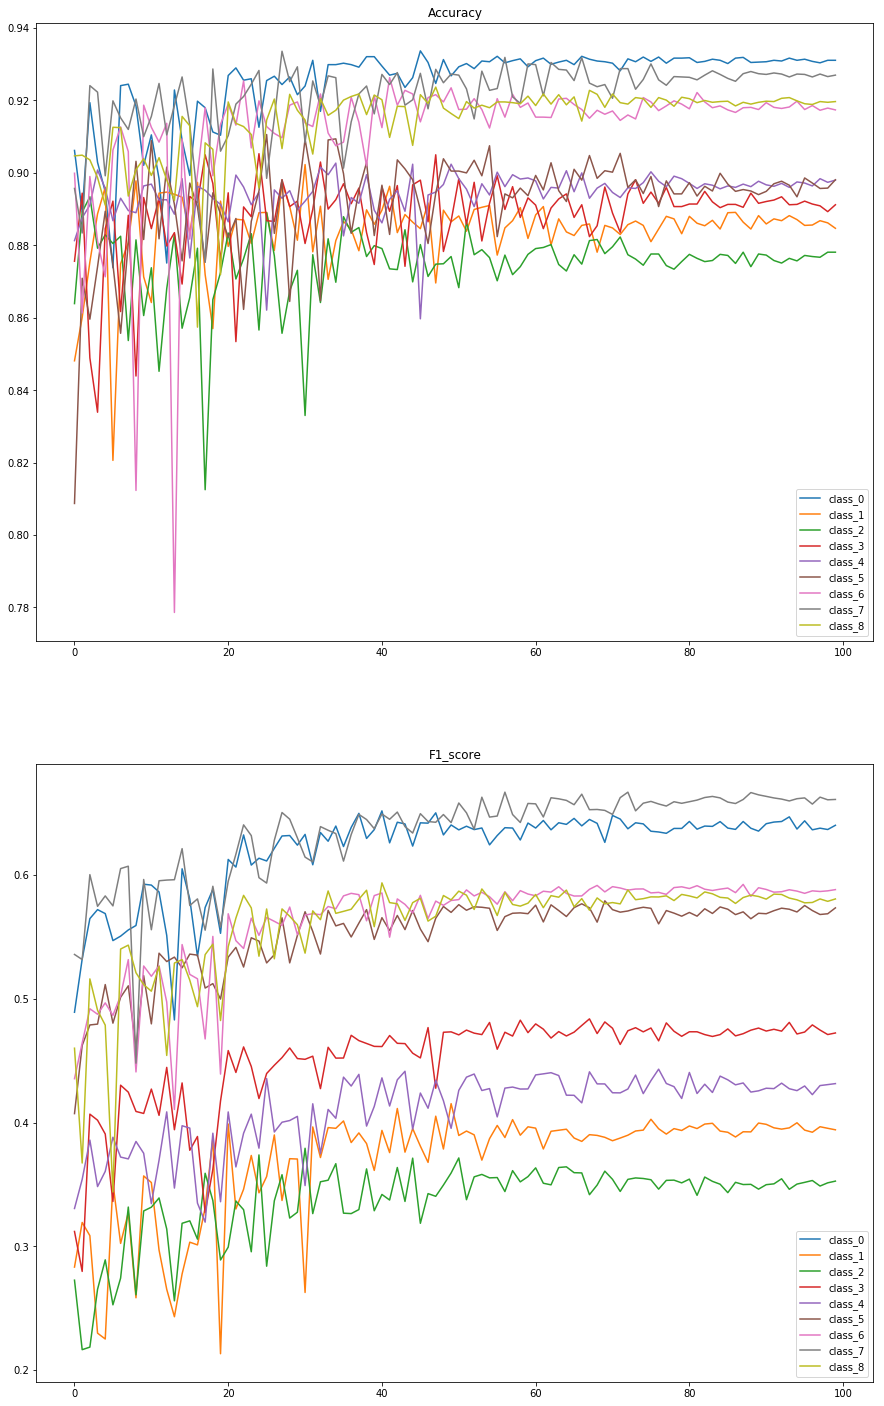

In [11]:
fig = plt.figure(figsize=[15, 25])
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for c in range(0, 9):
    tmp_cls = model.history.history['cls_'+str(c+1)]
    x = range(len(tmp_cls))
    y1, y2 = [], []
    for cc in range(len(tmp_cls)):
        y1.append(tmp_cls[cc]['ACC'])
        y2.append(tmp_cls[cc]['F1'])
    ax1.plot(x, y1, label='class_'+str(c))
    ax2.plot(x, y2, label='class_'+str(c))
ax1.set_title('Accuracy')
ax2.set_title('F1_score')
ax1.legend()
ax2.legend()
plt.show()